# Thompson sampling as a model for mouse decision making

The experimental paradigm is roughly the following: 
- A mouse performs a sequential decision making task in an environment with three nose ports. 
- Each step in the sequence begins when the mouse puts its nose in the center port. 
- After a brief pause, the mouse must decide to then poke its head in either the left port or the right port.
- One side yields a reward with high probability, the other with low probability.
- The rewarded side changes after a random duration of steps, $D \sim \mathrm{Unif}(40, 60)$.

In order to maximize its reward, the mouse must infer which side is most likely to yield reward and exploit this inference by going to that side. However, the moust must balance this tendency with the need to explore the alternative option, since the rewarded side changes periodically. 

One way to model the mouse's behavior is to think of it as a reinforcement learning agent that maintains a posterior distribution over which side is more likely to yield a reward and then samples its choice of side according to the probability that that side is more likely to yield a reward. This strategy is known as _Thompson sampling_.

We can approximate the experimental paradigm as a hidden Markov model (HMM) with a latent state $z_t \in \{0,1\}$ where 0="left" and 1="right". Likewise, at each time step the mouse performs an action $a_t \in \{0,1\}$, denoting its choice (left or right). After the mouse makes its choice, it receives a reward $r_t \in \{0,1\}$ with the following probability:

$\Pr(r_t = 1 \mid a_t, z_t) = \begin{cases} p & \text{if } a_t = z_t \\ q & \text{o.w.} \end{cases}$ 

where typically $p > 0.5$ and $q < 0.5$. Of course, 

$\Pr(r_t = 0 \mid a_t, z_t) = 1 - \Pr(r_t = 1 \mid a_t, z_t).$

The final piece is a model for how the latent state evolves. While the state truly switches randomly every 40 to 60 trials, this is actually a bit harder to model. Instead, we will use a very simple transition model in which the state stays the same with probability $s$ and changes with probability $1-s$. That yields the following transition matrix:

$\Pr(z_{t+1}=j \mid z_t=i ) = P_{ij}, $

where

$P = \begin{bmatrix} s & 1-s \\ 1-s & s \end{bmatrix}.$

**Note that this is a misspecified model!** This will generate geometrically distributed state durations, $D \sim \mathrm{Geom}(s)$, rather than uniform distributions, $D \sim \mathrm{Unif}(40,60)$. The true model is known as a _hidden semi-Markov model_ (HSMM), and while the procedure below would still work in principle, it would require a longer memory to implement.

Now we can formalize the Thompson sampling mouse. First it computes,

$ \Pr(z_t \mid a_1, r_1, \ldots, a_{t-1}, r_{t-1}).$

This is done recursively, as in the forward pass of an HMM inference algorithm.  Based on this state inference, it samples its action according to the probability that this action maximizes the reward. That is, 

$\Pr(a_t = 0) = \Pr(z_t = 0 \mid a_1, r_1, \ldots, a_{t-1}, r_{t-1}),$

$\Pr(a_t = 1) = \Pr(z_t = 1 \mid a_1, r_1, \ldots, a_{t-1}, r_{t-1}).$

In this way, the mouse still randomly explores both sides as long as there is some uncertainty over the latent state, which is always the case. 

To test whether this model is a good fit for the data, we can simulate the "Thompson mouse" and compute a probability of right vs left for each step and see how often it agrees with the mouse's actual behavior. 

Followed example for calculating forward probability from the [Forward-Backward algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm) wiki page

More notes on updating forward probability

$ \text{Let} \ \ b_{t+1} = p(z_{t+1} | r_{1:t}, a_{1:t}) $

Then

$ b_{t+1} = \sum_k p(z_{t+1} | z_t=k)  * p(z_t=k | r_{1:t}, a_{1:t})  \propto \sum_k p(z_{t+1} | z_t=k)  * p(r_t | z_t = k, a_t) * p(z_t=k | r_{t-1}, a_{t-1}) $

$ b_{t+1} = \sum_k p(z_{t+1} | z_t=k)  * p(r_t | z_t = k, a_t) * b_{t,k} $

In [1]:
import numpy as np
import numpy.random as npr
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [15]:
#parameters
n_plays = 100
duration = 20

#true latent state sequence
state = (np.arange(n_plays)) // duration % 2 #this just returns [0,0,....,1,1,...] etc 
#for each state so we can keep track. 

#transition matrix
'''
set transition matrix T such that T[i,j] is the probability of transitioning
from state i to state j. 
If the true number of trials before switching is 'duration', then set the
probability of switching to be 1 / duration, and the probability of 
staying to 1 - 1 / duration
'''
s = 1 - 1./duration
T = np.array([[s, 1.0-s],
             [1.0-s,s]])

#reward probabilties
p = 0.8 # prob of reward if choose the correct side
q = 0.2 # prob of reward if choose the incorrect side

#observation array
'''
set up array such that O[r,z,a] = Pr(reward=r | state=z,action=a)

eg. when action = L, observation matrix should be:
O[:,:,1]    = [P(r=0 | z=0,a=0),  P(r=0 | z=1,a=0)
               P(r=1 | z=0,a=0),  P(r=1 | z=1,a=0)]
            = [1-p, 1-q
                p,   q]
'''
O = np.zeros((2,2,2))
# let a 'right' choice be represented by '0'
O[:,:,0] = np.array([[1.0-p, 1.0-q],
                     [p,q]])
O[:,:,1] = np.array([[1.0-q, 1.0-p],
                     [q,p]])

#TEST: All conditional probability distributions must sum to one
assert np.allclose(O.sum(0),1), "All conditional probability distributions must sum to one!"

#Initialize an array for actions (a[i] = 0 --> right, a[i] = 1 --> left)
actions = np.zeros(n_plays)

#Initialize an array for rewards (outcomes) (1 = reward, 0 = no reward)
rewards = np.zeros(n_plays)

#Keep track of beliefs over which side will be rewarded
#First column is left, second is right
beliefs = np.nan*np.ones((n_plays+1,2)) # +1 since the belief is always about the next trial

#initialize with both sides equally likely
beliefs[0] = [0.5,0.5]

trials = np.zeros((n_plays,4))

#run the algorithm
for play in range(n_plays):
    assert np.allclose(beliefs[play].sum(), 1.0), "Beliefs must sum to one!"
    
    #choose an action
    '''
    different strategies could be employed here.
    eg 'greedy' <-- where action[play] = np.argmax(beliefs[play]). However
    this is actually suboptimal because it doesn't do any exploration. 
    
    in Thompson sampling, instead want to sample from your belief probabilities:
    ie actions[play] ~ beliefs[play]
    '''
    
    '''
    THOMPSON SAMPLING
    '''
    actions[play] = npr.choice(2,p=beliefs[play])
    '''
    GREEDY
    ''' 
    #actions[play] = np.where(beliefs[play] == beliefs[play].max())[0][0]
    
    '''
    EPSILON-GREEDY
    '''
    '''
    if np.random.uniform(size=1) > epsilon:
        actions[play] = np.where(beliefs[play] == beliefs[play].max())[0][0]
    else:
        actions[play] = np.where(beliefs[play] == beliefs[play].min())[0][0]
    '''
    
    #recieve reward based on the action
    p_reward = O[:,state[play],actions[play]]
    rewards[play] = npr.choice(2,p=p_reward) #bc of the way we set up the outcomes matrix, the first prob corresponds
    #to not getting a reward, so we get a 0 for no reward and a 1 for a reward :)
    
    
    '''
    update trial matrix
    1. time
    2. port (1=right,2=left)
    3. right port reward porb
    4. left port reward prob
    5. reward given 1/0
    
    obviously we won't encode a time.
    '''
    # action (port)
    trials[play,0] = actions[play]+5 #the 2s need to become zeros after
    
    
    if state[play] == 1: #we are in a 'left' state
        trials[play,[1,2]] = [q,p]
    else: # we are in a 'right' state
        trials[play,[1,2]] = [p,q]
    
    # outcome (reward given y/n)
    trials[play,3] = rewards[play]
    
    
    #update beliefs
    
    #step 1: multiply by p(r_t | z_t = k, a_t)
    belief_temp = O[rewards[play],:,actions[play]] * beliefs[play]
    
    #step 2: sum over z_t, weighting by transition matrix
    beliefs[play+1] = T.dot(belief_temp)
    
    #step 3: normalize
    beliefs[play+1] /= beliefs[play+1].sum()

#switch ports
trials[trials[:,0] == 5,0] = 1
trials[trials[:,0] == 6,0] = 2


//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:94: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:125: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


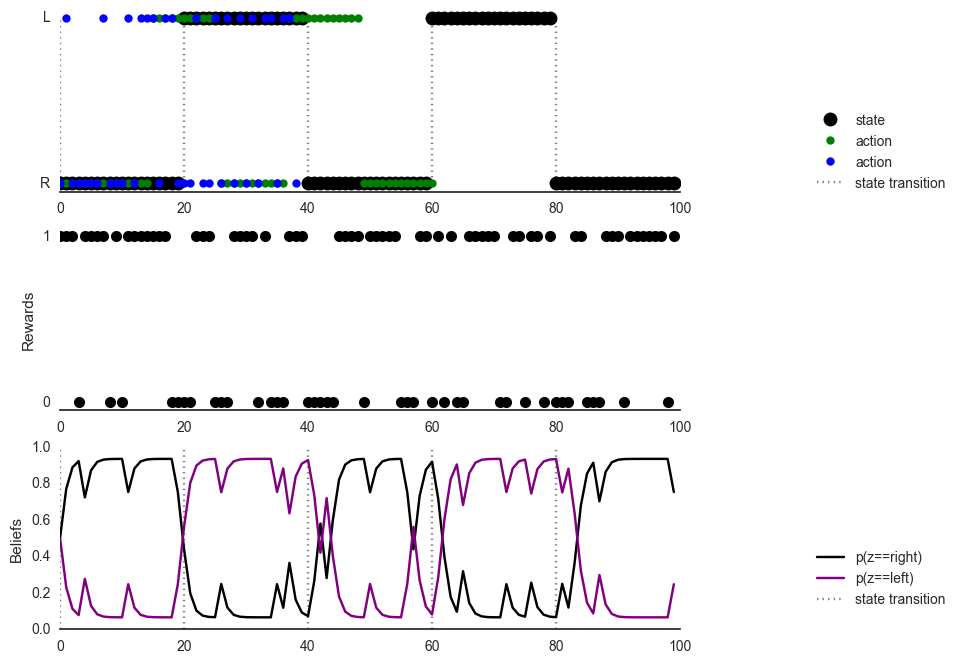

In [27]:
# Plot
sns.set_style('white')
plt.figure(figsize=(8,8))

plt.subplot(311)
plt.plot(state, 'ko', markersize=10, markeredgecolor="none", label="state",alpha=1.0)
#plt.plot(actions, 'bo', markersize=6, markeredgecolor="none", label="action")
plt.plot(actions[np.where(rewards==1)], 'go', markersize=6, markeredgecolor="none", label="action")
plt.plot(actions[np.where(rewards==0)], 'bo', markersize=6, markeredgecolor="none", label="action")

for x in range(0,n_plays,duration):
    label = 'state transition' if x==0 else None
    plt.vlines(x=x, ymin=0, ymax=1, color='grey', linestyles=':', label=label)
plt.legend(loc="upper left", bbox_to_anchor=(1.2,0.5,0,0))
plt.yticks([0,1], ["R", "L"])
plt.ylim(-0.05,1.05)

plt.subplot(312)
plt.plot(rewards, 'ko', markersize=8)
plt.ylabel("Rewards")
plt.yticks([0,1])
plt.ylim(-0.05,1.05)

plt.subplot(313)
plt.plot(np.arange(n_plays), beliefs[:-1, 0], color='black', label='p(z==right)')
plt.plot(np.arange(n_plays), beliefs[:-1, 1], color='purple', label='p(z==left)')
sns.despine(left=True)
for x in range(0,n_plays,duration):
    label = 'state transition' if x==0 else None
    plt.vlines(x=x, ymin=0, ymax=1, color='grey', linestyles=':', label=label)
plt.legend(loc="upper left", bbox_to_anchor=(1.2,0.5,0,0))
plt.ylim(0,1)
plt.ylabel("Beliefs")

In [23]:
actions[list(map(bool,rewards))]

//anaconda/envs/CaGRIN/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  if __name__ == '__main__':


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [25]:
actions[np.where(rewards==1)]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [4]:
np.savetxt('/Users/shayneufeld/GitHub/mouse_bandit/data/trials_hmm_full_7030_greedy.csv',trials,delimiter=',')